# import packages and functions

In [11]:
import sys
import argparse
from lib2to3.pytree import Base
import torch
import numpy as np
import pandas as pd
import random
import yaml
import gc
import time
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
import pyro
from pyro.infer import SVI,  JitTraceEnum_ELBO, Trace_ELBO, config_enumerate
from pyro.optim import Adam, ExponentialLR
import torchmetrics
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as Data
import scanpy as sc

In [3]:
def set_rng_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

In [4]:
device = torch.device("cuda")
set_rng_seed(2222)

In [6]:
# input params
parser = argparse.ArgumentParser()
def load_yaml_config(file_path):
    with open(file_path, encoding='utf-8') as f:
        return yaml.load(f, Loader=yaml.FullLoader)['gcn']
    
config = load_yaml_config('./param.yaml')
args = { }
for key in config.keys():
    name = key
    if name not in args:
        args[name] = config[key]
print("Parsed arguments:")
for key, value in args.items():
    print(f"{key}: {value}")


Expression_data_path = "./demo_data/A549/ExpressionData.csv"
Genescore_data_path = "./demo_data/A549/GeneScoreData.csv"
label_path = "./demo_data/A549/refNetwork.csv"

Parsed arguments:
cuda: True
seed: 2222
lr: 0.0003
weight_decay: 0.001
decayrate: 0.97
hidden: 256
dropout: 0.1
epoches: 2000
ns: 64
alpha: 0.35


In [18]:
genes = pd.read_table(Expression_data_path,sep=',',index_col=0).index

In [7]:
def SetupVAELoss(Model, adam_params = None, decayRate = None):
    optimizer = torch.optim.Adam
    if adam_params is None:
        adam_params = {'lr': 3e-4, 'betas':(0.99, 0.999), 'weight_decay': 0.001} # default
    if decayRate is None:
        decayRate = 0.97
    scheduler = ExponentialLR({'optimizer': optimizer, 'optim_args': adam_params, 'gamma': decayRate})
    pyro.clear_param_store()
    guide = config_enumerate(Model.guide, expand = True)
    elbo = JitTraceEnum_ELBO(max_plate_nesting = 1, strict_enumeration_warning = False)
    loss_basic = SVI(Model.model, guide, scheduler, loss = elbo)
    losses = [loss_basic]
    elbo =  Trace_ELBO()
    loss_aux = SVI(Model.model_GRNrecon, Model.guide_GRNrecon, scheduler, loss = elbo)
    losses.append(loss_aux)
    return losses, scheduler

In [10]:
import prism

ModuleNotFoundError: No module named 'prism'

## binary

### load data

In [24]:
args['flag'] = False
adj_train, feature, feature_ATAC, train_ids, val_ids, test_ids, train_labels, val_labels, test_labels = load_sc_data(Expression_data_path, Genescore_data_path, label_path)
adj_train = F.normalize(adj_train, p=1, dim=1)

In [25]:

scc = model4.BioGRN(nfeat=feature.shape[1],     ## the size of feature -> cell num
                    nhid=args['hidden'],         ## hidden layer size
                    dropout=args['dropout'],     ## hyperparameter
                    ns=args['ns'],               ## the size of VAE node embedding 
                    alpha=args['alpha'],         ## hyperparameter
                    flag=args['flag']).to(device)
# move to CUDA

# optimizer = optim.Adam(scc.parameters(),
#                     lr=args['lr'],
#                     weight_decay=args['weight_decay'])

BCE_loss = torch.nn.BCELoss(reduction='mean')
BCEWL_loss = torch.nn.BCEWithLogitsLoss(reduction = 'mean')

In [26]:
if args['cuda']:
    adj_train = adj_train.to(device)
    feature = feature.to(device)
    feature_atac = feature_ATAC.to(device) # 后续再修改
    train_ids = train_ids.to(device)
    val_ids = val_ids.to(device)
    test_ids = test_ids.to(device)
    train_labels = train_labels.to(device).long()
    val_labels = val_labels.to(device).long()
    test_labels = test_labels.to(device).long()
    weight_CE = torch.FloatTensor([1, 23, 23]).to(device)

### step train

In [27]:
def Get_metrics(predicted_y, y_prob, y_true):
    correct_prediction = torch.eq(torch.topk(predicted_y, 1)[1].squeeze(), y_true)
    accuracy = torch.mean(correct_prediction.type(torch.FloatTensor))
    AUC = roc_auc_score(y_true.cpu().numpy(), y_prob[:,1].cpu().detach().numpy())
    AUPRC = average_precision_score(y_true.cpu().numpy(), y_prob[:,1].cpu().detach().numpy())
    return accuracy.item(),AUC, AUPRC

In [28]:
losses,scheduler = SetupVAELoss(scc)
train_labels_onehot = F.one_hot(train_labels, 2)
val_labels_onehot = F.one_hot(val_labels, 2)
test_labels_onehot = F.one_hot(test_labels, 2)

In [29]:
## train
loss_reconRNA = []
loss_reconGRN = []
best_acc_val = 0
best_acc_tst = 0
best_roc_test = 0
best_ap_test = 0
for i in range(2000):
    loss1 = losses[0].step(feature, feature_atac, adj_train, train_ids, train_labels_onehot)
    loss_reconRNA.append(loss1)
    loss2 = losses[1].step(feature, feature_atac, adj_train, train_ids, train_labels_onehot)
    loss_reconGRN.append(loss2)
    if (i+1)%100 ==0:
        val_loss1 = losses[0].step(feature, feature_atac, adj_train, val_ids, val_labels_onehot)
        val_loss2 = losses[1].step(feature, feature_atac, adj_train, val_ids, val_labels_onehot)
        val_y, val_y_prob = scc.classifier(feature, adj_train, val_ids)
        val_acc, val_AUC, val_AUPRC = Get_metrics(val_y, val_y_prob,val_labels)
        print(f'On validation epoch {i+1}: RNA recon loss {val_loss1}, GRN recon loss {val_loss2}')
        if best_acc_val <  val_acc:
            test_y, test_y_prob = scc.classifier(feature, adj_train, test_ids)
            test_acc, test_AUC, test_AUPRC = Get_metrics(test_y, test_y_prob,test_labels)
            best_acc_tst = test_acc
            best_roc_test = test_AUC
            best_auprc_test = test_AUPRC        

On validation epoch 100: RNA recon loss 58155.390625, GRN recon loss 47884.25390625
On validation epoch 200: RNA recon loss 19343.4375, GRN recon loss 45629.8203125
On validation epoch 300: RNA recon loss 20114.640625, GRN recon loss 31936.171875
On validation epoch 400: RNA recon loss 18044.484375, GRN recon loss 26222.39453125
On validation epoch 500: RNA recon loss 17108.703125, GRN recon loss 25033.921875
On validation epoch 600: RNA recon loss 17129.1875, GRN recon loss 24377.451171875
On validation epoch 700: RNA recon loss 17125.703125, GRN recon loss 23994.033203125
On validation epoch 800: RNA recon loss 17017.03125, GRN recon loss 23876.90234375
On validation epoch 900: RNA recon loss 16960.015625, GRN recon loss 23669.1875
On validation epoch 1000: RNA recon loss 16944.5625, GRN recon loss 23601.767578125
On validation epoch 1100: RNA recon loss 16909.640625, GRN recon loss 23555.1953125
On validation epoch 1200: RNA recon loss 16820.234375, GRN recon loss 23349.54296875
On 

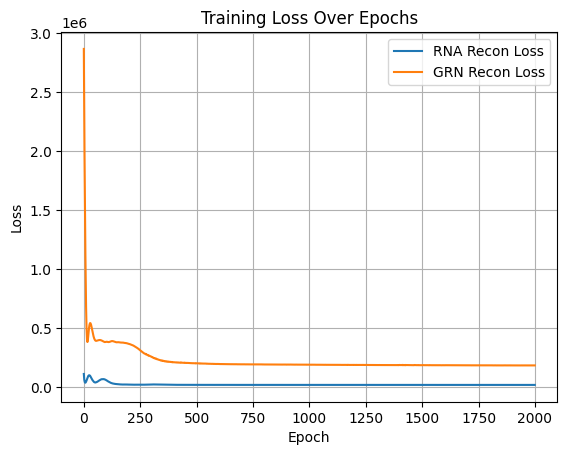

In [30]:
import matplotlib.pyplot as plt
# 使用 Matplotlib 画出损失曲线
plt.plot(loss_reconRNA, label='RNA Recon Loss')
plt.plot(loss_reconGRN, label='GRN Recon Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

### test

In [31]:
def Get_metrics(predicted_y, y_prob, y_true):
    correct_prediction = torch.eq(torch.topk(predicted_y, 1)[1].squeeze(), y_true)
    accuracy = torch.mean(correct_prediction.type(torch.FloatTensor))
    AUC = roc_auc_score(y_true.cpu().numpy(), y_prob[:,1].cpu().detach().numpy())
    AUPRC = average_precision_score(y_true.cpu().numpy(), y_prob[:,1].cpu().detach().numpy())
    return accuracy.item(),AUC, AUPRC
test_y, test_y_prob = scc.classifier(feature, adj_train, test_ids)
test_acc, test_AUC, test_AUPRC = Get_metrics(test_y, test_y_prob,test_labels)

In [32]:
print(test_acc, test_AUC, test_AUPRC)
# torch.save(scc.state_dict(), "%s/model4_binary.pkl" % '/home/xzx/zwh/BioGRN/BIOTEST/tem_models')

0.9753788709640503 0.9708411983719496 0.47850966929183075


## triple

In [7]:
args['flag'] = True
if args['flag']:
    Eval_acc = torchmetrics.Accuracy(task='multiclass', num_classes = 3).to(device)
    Eval_auc = torchmetrics.AUROC(task='multiclass', num_classes = 3).to(device)
    Eval_ap = torchmetrics.AveragePrecision(task="multiclass", num_classes = 3).to(device)

In [8]:
args['flag'] = 'True'

if args['flag']:
    adj_train, feature, feature_atac, train_ids, val_ids, test_ids, train_labels, val_labels, test_labels = load_sc_causal_data(Expression_data_path, Genescore_data_path, label_path)
else:
    adj_train, feature, feature_atac, train_ids, val_ids, test_ids, train_labels, val_labels, test_labels = load_sc_data(Expression_data_path, Genescore_data_path, label_path)

adj_train = F.normalize(adj_train, p=1, dim=1)

read data complete!
log the expression data
process the ground truth!
find all negative edges and split them for training and testing!


In [9]:
scc = model4.BioGRN(nfeat=feature.shape[1],     ## the size of feature -> cell num
                    nhid=args['hidden'],         ## hidden layer size
                    dropout=args['dropout'],     ## hyperparameter
                    ns=args['ns'],               ## the size of VAE node embedding 
                    alpha=args['alpha'],         ## hyperparameter
                    flag=args['flag']).to(device)
# move to CUDA

# optimizer = optim.Adam(scc.parameters(),
#                     lr=args['lr'],
#                     weight_decay=args['weight_decay'])

BCE_loss = torch.nn.BCELoss(reduction='mean')
BCEWL_loss = torch.nn.BCEWithLogitsLoss(reduction = 'mean')

In [10]:
if args['cuda']:
    adj_train = adj_train.to(device)
    feature = feature.to(device)
    feature_atac= feature_atac.to(device) # 后续再修改
    train_ids = train_ids.to(device)
    val_ids = val_ids.to(device)
    test_ids = test_ids.to(device)
    train_labels = train_labels.to(device).long()
    val_labels = val_labels.to(device).long()
    test_labels = test_labels.to(device).long()
    weight_CE = torch.FloatTensor([1, 23, 23]).to(device)

### step train

In [41]:
losses,scheduler = SetupVAELoss(scc)
train_labels_onehot = F.one_hot(train_labels, 3)
val_labels_onehot = F.one_hot(val_labels, 3)
test_labels_onehot = F.one_hot(test_labels, 3)

In [42]:
if args['flag']:
    Eval_acc = torchmetrics.Accuracy(task='multiclass', num_classes = 3).to(device)
    Eval_auc = torchmetrics.AUROC(task='multiclass', num_classes = 3).to(device)
    Eval_ap = torchmetrics.AveragePrecision(task="multiclass", num_classes = 3).to(device)

In [43]:
## train
loss_reconRNA = []
loss_reconGRN = []
best_acc_val = 0
best_acc_tst = 0
best_roc_test = 0
best_ap_test = 0
for i in range(2000):
    loss1 = losses[0].step(feature, feature_atac, adj_train, train_ids, train_labels_onehot)
    loss_reconRNA.append(loss1)
    loss2 = losses[1].step(feature, feature_atac, adj_train, train_ids, train_labels_onehot)
    loss_reconGRN.append(loss2)
    if (i+1)%100 ==0:
        val_loss1 = losses[0].step(feature, feature_atac, adj_train, val_ids, val_labels_onehot)
        val_loss2 = losses[1].step(feature, feature_atac, adj_train, val_ids, val_labels_onehot)
        val_y, val_y_prob = scc.classifier(feature, adj_train, val_ids)
        val_acc = Eval_acc(val_y_prob , val_labels)
        print(f'On validation epoch {i+1}: RNA recon loss {val_loss1}, GRN recon loss {val_loss2}')
        if best_acc_val <  val_acc:
            test_y, test_y_prob = scc.classifier(feature, adj_train, test_ids)
            test_acc = Eval_acc(test_y_prob , test_labels).item() 
            test_AUC = Eval_auc(test_y_prob, test_labels).item()
            test_AUPRC = Eval_ap(test_y_prob, test_labels).item()
            best_acc_tst = test_acc
            best_roc_test = test_AUC
            best_auprc_test = test_AUPRC
            best_acc_val = val_acc

On validation epoch 100: RNA recon loss 71194.109375, GRN recon loss 94702.25
On validation epoch 200: RNA recon loss 20283.71875, GRN recon loss 75146.96875
On validation epoch 300: RNA recon loss 24467.359375, GRN recon loss 46843.13671875
On validation epoch 400: RNA recon loss 20247.1875, GRN recon loss 42195.85546875
On validation epoch 500: RNA recon loss 18488.046875, GRN recon loss 41216.4921875
On validation epoch 600: RNA recon loss 18403.875, GRN recon loss 40213.7265625
On validation epoch 700: RNA recon loss 18331.078125, GRN recon loss 39646.0703125
On validation epoch 800: RNA recon loss 18387.0625, GRN recon loss 38774.88671875
On validation epoch 900: RNA recon loss 18377.75, GRN recon loss 37627.52734375
On validation epoch 1000: RNA recon loss 18154.171875, GRN recon loss 36946.6796875
On validation epoch 1100: RNA recon loss 17878.96875, GRN recon loss 36660.41015625
On validation epoch 1200: RNA recon loss 17716.265625, GRN recon loss 36437.8046875
On validation ep

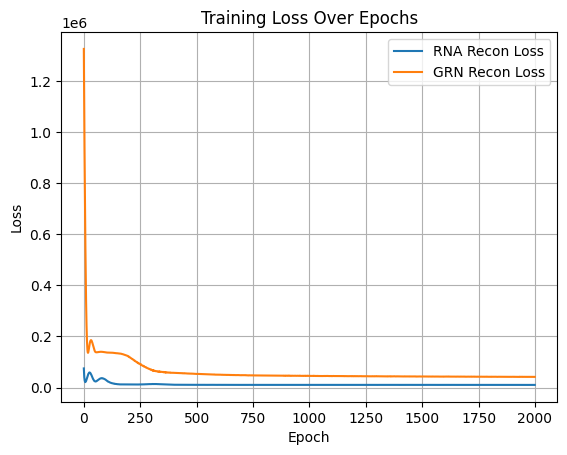

In [22]:
import matplotlib.pyplot as plt
# 使用 Matplotlib 画出损失曲线
plt.plot(loss_reconRNA, label='RNA Recon Loss')
plt.plot(loss_reconGRN, label='GRN Recon Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

### test

In [44]:
print("best_acc_test:{:.4f}".format(best_acc_tst))
print("best_AUC_test:{:.4f}".format(best_roc_test))
print("best_AUPRC_test:{:.4f}".format(best_auprc_test))

best_acc_test:0.9616
best_AUC_test:0.9809
best_AUPRC_test:0.7668


In [26]:
torch.save(scc.state_dict(), "%s/PRISM.pkl" % '/home/xzx/zwh/BioGRN/downsteam/GeneModules/')

# Visualize

In [11]:
state_dict = torch.load('/home/xzx/zwh/BioGRN/BIOTEST/tem_models/model4_triple.pkl')
scc.load_state_dict(state_dict)
scc = scc.to(device)

In [12]:
### using recon RNA
XGATembedding = scc.GeneGRNEncoder(feature, adj_train)
zrna_loc, _ = scc.encoder_RNA(feature)
zatac_loc, _ = scc.encoder_ATAC(feature_atac)
zgrn_loc, _= scc.encoder_GAT(XGATembedding)
thetas = scc.decoder_RNA ([zrna_loc, zatac_loc, zgrn_loc])

In [13]:
import pyro.distributions as dist
thetas = scc.cutoff(thetas)
max_count = torch.ceil(abs(feature).sum(1).sum()).int().item()
recon_RNA = pyro.sample('XRNA', dist.DirichletMultinomial(total_count = max_count, concentration=thetas))

## Gene UMAP based on Expression

In [24]:
feature.cpu().numpy().shape

(1245, 3260)

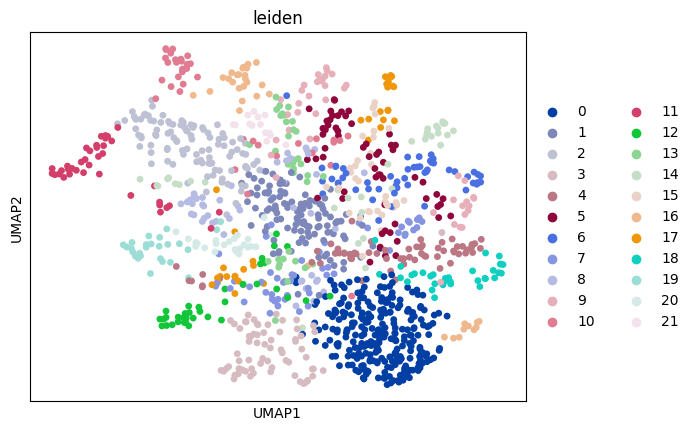

In [57]:
import matplotlib
import matplotlib.pyplot as plt

# Set the font type to Type 42 (TrueType) to ensure text is saved as text in the PDF
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
adata_gene_raw = sc.AnnData(feature.cpu().numpy())
adata_gene_raw.obs['names'] = pd.DataFrame(genes, columns=['names'])
sc.tl.pca(adata_gene_raw, svd_solver='arpack')
sc.pp.neighbors(adata_gene_raw )
sc.tl.leiden(adata_gene_raw)
sc.tl.umap(adata_gene_raw )
sc.pl.umap(adata_gene_raw ,color = 'leiden',save='UMAP_A549_RAW.pdf')
# plt.savefig('/home/xzx/zwh/BioGRN/downsteam/GeneModules/UMAP_A549_RAW', format='.pdf', bbox_inches='tight')

## Gene UMAP based on embedding

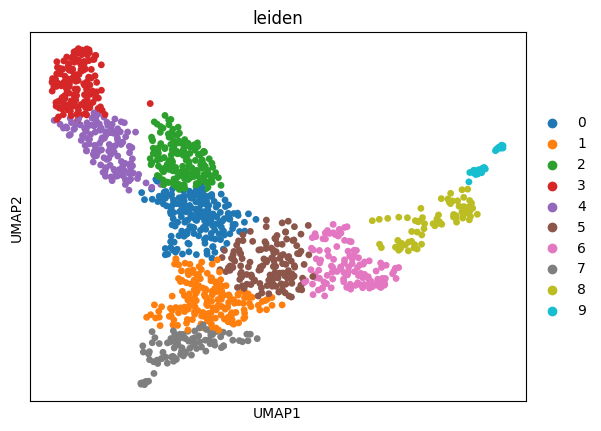

In [58]:
adata_gene = sc.AnnData(zgrn_loc.detach().cpu().numpy())
adata_gene.obs['names'] = genes.values
sc.tl.pca(adata_gene, svd_solver='arpack')
sc.pp.neighbors(adata_gene)
sc.tl.leiden(adata_gene)
sc.tl.umap(adata_gene)
sc.pl.umap(adata_gene,color = 'leiden',save='UMAP_A549_Trained.pdf')

In [70]:
gene_module = adata_gene[adata_gene.obs['leiden']=='9'].obs['names'].values
for item in gene_module:
    print (item)

ZMYM4-AS1
GJA9
SV2A
TMEM81
C3orf22
GABRA4
SCRG1
FEZF1
MIR548V
GNRH1
PAPPA-AS1
CYP26C1
TPH1
C1QTNF4
FAM90A1
PLCZ1
LINC00376
NDN
LAMA1
ACP5
TSSK6
LYPD4
GP6
TCEAL6


In [52]:
for item in genes:
    print (item)

HES4
ACAP3
DVL1
MXRA8
AURKAIP1
TMEM240
HES5
RPL22
HES2
TNFRSF25
ENO1
FBXO2
MAD2L2
NPPA
KAZN
CASP9
ZBTB17
ARHGEF19
MST1L
ATP13A2
AKR7L
MUL1
RAP1GAP
WNT4
KDM1A
HTR1D
ZNF436
E2F2
FUCA1
RUNX3
UBXN11
ARID1A
GPATCH3
FGR
SNORD99
TMEM200B
MATN1-AS1
SDC3
HCRTR1
MARCKSL1
FNDC5
HPCA
TMEM54
ZSCAN20
GJB5
ZMYM4-AS1
C1orf216
LSM10
MRPS15
FHL3
GJA9
HEYL
CITED4
SLFNL1
HYI
BEST4
HECTD3
PRDX1
CCDC17
RPS15AP10
POMGNT1
TEX38
PDZK1IP1
FOXD2-AS1
KTI12
FAM151A
PARS2
DHCR24
JUN
FOXD3
MCOLN3
GBP3
GBP2
COL11A1
MYBPHL
SYPL2
AMIGO1
GSTM3
EPS8L3
LAMTOR5
DENND2D
CHIA
WDR77
RHOC
BCL2L15
AP4B1
NBPF20
SV2A
SF3B4
MTMR11
ADAMTSL4-AS1
MCL1
ARNT
SEMA6C
RFX5
RORC
S100A10
TCHH
SMCP
S100A6
S100A5
S100A4
S100A3
S100A2
S100A14
CRTC2
SLC39A1
JTB
SHE
MUC1
RUSC1-AS1
PAQR6
CCT3
CRABP2
LRRC71
ETV3L
IGSF8
PEX19
SLAMF6
USF1
HSPA6
PBX1
METTL18
ANGPTL1
RGS16
RNF2
B3GALT2
ASPM
NR5A2
TNNT2
LAD1
CSRP1
ZC3H11A
ETNK2
TMEM81
SNORD60
HSD11B1
C1orf74
ATF3
CAPN8
LEFTY1
JMJD4
LYST
PDIA6
E2F6
NTSR2
OSR1
LINC00954
LAPTM4A
SDC1
TP53I3
PTRHD1
SLC5A6


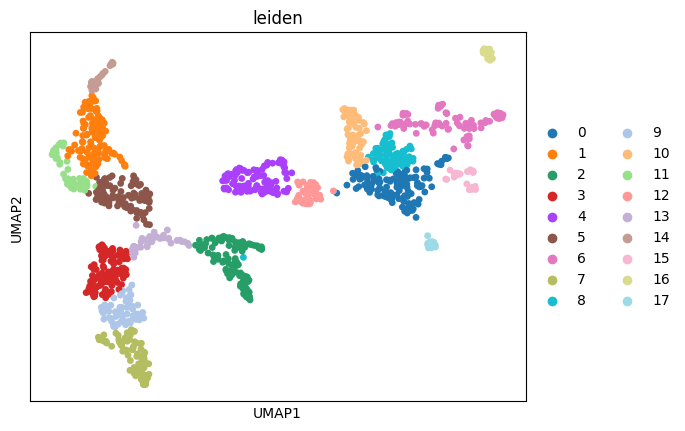

In [15]:
adata_gene2 = sc.AnnData(XGATembedding.detach().cpu().numpy())
sc.tl.pca(adata_gene2, svd_solver='arpack')
sc.pp.neighbors(adata_gene2)
sc.tl.leiden(adata_gene2)
sc.tl.umap(adata_gene2)
sc.pl.umap(adata_gene2,color = 'leiden')